In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(100)

# Read Dataset

In [3]:
data = pd.read_csv('./data/shanghai_experience.csv')

## Dataset Explaination

* the varible `low` is our label y, low = 0 means low salary, low = 1 means high salary
* Other varibles is our features X

notice that y is a vector and X is a matrix.

Some featues:
* `career_algorithm`, `career_architect`, `career_software_engineer` mean which career the person has. We use one-hot-encoding here
* `pl_go`, `pl_c_sharp` ... mean which language the person uses.

There are totally over 100 features, I won't explain all of them. For simplicity, all features are boolean type.

In [4]:
data.head()

,ageism,career_algorithm,career_architect,career_software_engineer,company_size_10000,company_size_1000_5000,company_size_150_500,company_size_50,company_size_5000_10000,company_size_500_1000,...,ml_mxnet,ml_chainer,ml_keras,ml_deeplearning4j,ml_theano,ml_sklearn,ml_mahout,ml_paddlepaddle,career_spider,low
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [5]:
# 4891 rows，128 cols
data.shape

(4891, 128)

In [6]:
# see some info about low, i.e. y label
data.describe()

,low
count,4891.000000
mean,0.541198
std,0.498351
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# Decision Tree

## Purity Evaluation
We can evaluate purity by entropy or gini index

### Information Entropy

There is a variable X (feature), and the probability distribution of this X is:

$$P\left(X=x_{i}\right)=p_{i}, \quad i=1,2, \cdots, n$$

Therefore, information entropy of varible X is:

$$H(X)=-\sum_{i=1}^{n} p_{i} \log p_{i}$$


In [7]:
def get_entropy(counts):
    """Get the entropy value from a count list
    
    Parameters
    ----------
    counts: Number of occurrences of different values
    
    Returns
    -------
    entropy: Entropy of the dataset
    """
    
    percentages = counts / np.sum(counts)
    entropy = sum([ - pct * np.log2(pct) for pct in percentages if pct != 0])
    return entropy

In [8]:
get_entropy([0, 1])

0.0

In [9]:
get_entropy([3, 3])

1.0

In [10]:
get_entropy([3, 4, 7])

1.4926140680171258

In [11]:
# get the entropy of the entire dataset
counts_y = [sum(data['low'] == 0), sum(data['low'] == 1)]
get_entropy(counts_y)

0.9950971141240397

### Gini Coefficient

In IDS Lecture slides, it don't mention about gini which is also a common tool to do purity evaluation.

* **Information entropy** is used for **ID3 trees** (one type of decision trees)
* **Gini coefficient** is used for **CART trees** (one type of decision trees)

What is Gini coefficient?

There is a variable X (feature), and the probability distribution of this X is:

$$P\left(X=x_{i}\right)=p_{i}, \quad i=1,2, \cdots, n$$

Therefore, gini coefficient of varible X is:

$$\operatorname{Gini}(p)=\sum_{k=1}^{K} p_{k}\left(1-p_{k}\right)=1-\sum_{k=1}^{K} p_{k}^{2}$$

In [12]:
def get_gini(counts):
    """Get the gini index value from a count list
    
    Parameters
    ----------
    counts: Number of occurrences of different values
    
    Returns
    -------
    gini: Gini of the dataset
    """
    
    percentages = counts / np.sum(counts)
    gini = 1 - sum([pct ** 2 for pct in percentages])
    return gini

In [13]:
get_gini([0,100])

0.0

In [14]:
get_gini([50,50])

0.5

In [15]:
# get gini of the entire dataset
counts_y = [sum(data['low'] == 0), sum(data['low'] == 1)]
get_gini(counts_y)

0.49660542998270074

### Curves of Entropy and Gini
The curve of half entropy (1/2 * entropy) and gini are very similar

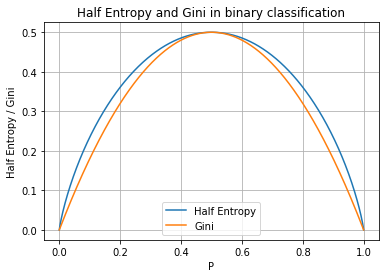

In [16]:
fig, ax = plt.subplots()

# calculate points in functions
x_list = [i / 1000 for i in list(range(1001))]
half_entropy_list = [ 1/2 * get_entropy([x, 1 - x]) for x in x_list]
gini_list = [get_gini([x, 1 - x]) for x in x_list]

# draw functions
ax.plot(x_list, half_entropy_list, label="Half Entropy")
ax.plot(x_list, gini_list, label="Gini")
ax.set_xlabel('P')
ax.set_ylabel('Half Entropy / Gini')
ax.set_title('Half Entropy and Gini in binary classification')
ax.grid()
ax.legend()

## Information Gain

Before talking about information gain, we can introduce conditional entropy first

**Conditional entropy**: H(Y|X) means the uncertainties of variable Y in the condition of variable X. Specifically

$$H(Y \mid X)=\sum_{i=1}^{n} p_{i} H\left(Y \mid X=x_{i}\right)$$

Then we can get the information gain by:

$$g(Y, X)=H(Y)-H(Y \mid X)$$

In IDS slides, we have an example:

![image.png](https://tva1.sinaimg.cn/large/007S8ZIlly1gjr7grf0hzj30zs0qwahn.jpg)

**The intuition of information gain is that we gain information (get purier groups) by dividing the whole group into several groups by a feature.**
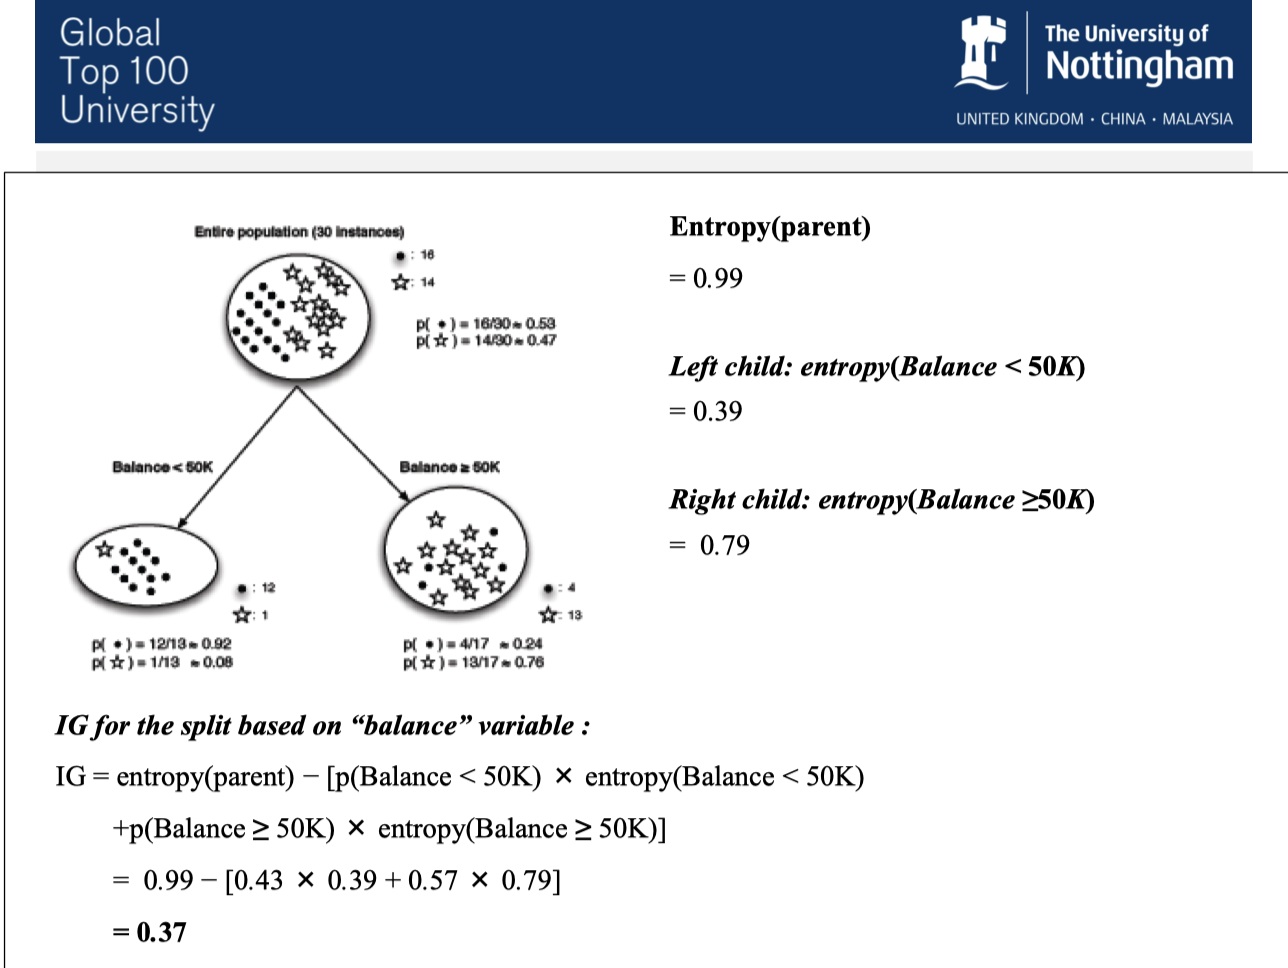

In [29]:
def info_entropy(data, label="low"):
    """Get the entropy value from dataset directly (for binary classification)
    
    Parameters
    ----------
    data: Dataset
    label: The name of the column of the label y
    
    Returns
    -------
    entropy: Entropy of the dataset
    """
    
    counts_y = [sum(data[label] == 0), sum(data[label] == 1)]
    entropy = get_entropy(counts_y)
    return entropy

In [30]:
info_entropy(data)

0.9950971141240397

In [31]:
def cdtn_entropy(data, feature, label="low"):
    """Get the conditional entropy value (for binary classification)
    
    Parameters
    ----------
    data: Dataset
    feature: The feature to divide dataset
    label: The name of the column of the label y
    
    Returns
    -------
    entropy: Entropy of the dataset
    """
    
    data1 = data[data[feature]]
    data2 = data[~data[feature]]
    entrop1 = info_entropy(data1, label)
    entrop2 = info_entropy(data2, label)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    n = n1 + n2
    return n1/n * entrop1 + n2/n * entrop2

In [32]:
cdtn_entropy(data, feature="edu_associate")

0.9330339884305898

`edu_associate` means 大专学位, so the information gain is:

In [34]:
# calculate information gain for the feature edu_associate
info_entropy(data) - cdtn_entropy(data, feature="edu_associate")

0.06206312569344985

## Decision Tree Algorithm

In [16]:
msk = np.random.rand(len(data)) < 0.8
data_train = data[msk]
data_test = data[~msk]
X_train = data_train.drop('low', axis=1)
y_train = data_train['low']
X_test = data_test.drop('low', axis=1)
y_test = data_test['low']

In [17]:
class Branch:
    no=0
    depth=1
    column=''
    entropy=0
    samples=0
    value=[]
    
    branch_positive=None
    branch_negative=None
    no_positive=0
    no_negative=0

In [18]:
number=0

def data_entropy(data):
    n_rows=data.shape[0]
    n_low=data[data.low==1].shape[0]
    n_high=n_rows-n_low
    return get_entropy([n_low, n_high])

def data_entropy2(data1, data2):
    entrop1=data_entropy(data1)
    entrop2=data_entropy(data2)
    n1=data1.shape[0]
    n2=data2.shape[0]
    n=n1+n2
    return n1/n*entrop1+n2/n*entrop2

def find_best_feature(data, label):
    X=data.drop(label, axis=1)
    min_entropy=1
    col_selected=''
    data_positive_found=None
    data_negative_found=None
    for col in X.columns:
        data_positive=data[data[col]==1]
        data_negative=data[data[col]==0]
        if data_positive.shape[0]==0:
            continue
        if data_negative.shape[0]==0:
            continue
        entropy=data_entropy2(data_positive, data_negative)
        #print(gain,entropy,entropy_new)
        if entropy<min_entropy:
            min_entropy=entropy
            col_selected=col
            data_positive_found=data_positive
            data_negative_found=data_negative
    return col_selected, min_entropy, data_positive_found, data_negative_found

def decision_tree_inner(data, label, depth, max_depth=3):
    global number
    branch = Branch()
    branch.no=number
    number=number+1
    branch.depth=depth
    
    branch.samples=data.shape[0]
    n_positive=data[data[label]==1].shape[0]
    branch.value=[branch.samples-n_positive,n_positive]
    branch.entropy=get_entropy(branch.value)
    best_feature = find_best_feature(data, label)
    branch.column=best_feature[0]
    new_entropy=best_feature[1]
    if depth==max_depth or branch.column=='':
        branch.no_positive=number
        number=number+1
        branch.no_negative=number
        number=number+1
        return branch
    else:
        data_negative=best_feature[3]
        branch.branch_negative=decision_tree_inner(data_negative, label, depth+1, max_depth=max_depth)
        data_positive=best_feature[2]
        branch.branch_positive=decision_tree_inner(data_positive, label, depth+1, max_depth=max_depth)

        return branch

def decision_tree(data, label, max_depth=3):
    number=0
    entropy=data_entropy(data)
    tree=decision_tree_inner(data, label, 0, max_depth=3)
    return tree

In [19]:
my_dt = decision_tree(data_train, 'low', max_depth=2)

In [20]:
my_dt

# Visulization

In [21]:
def get_dot_data_innner(branch:Branch, classes, dot_data):
    if branch.value[0]<branch.value[1]:
        the_class=classes[0]
    else:
        the_class=classes[1]
    if branch.branch_positive:
        dot_data=dot_data+'{} [label=<{}?<br/>entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.column, branch.entropy, branch.samples, branch.value, the_class)
    else:
        dot_data=dot_data+'{} [label=<entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.entropy, branch.samples, branch.value, the_class)
    if branch.branch_negative:
        dot_data=dot_data+'{} -> {} [labeldistance=2.5, labelangle=45, headlabel="no"]; \r\n'.format(branch.no, branch.branch_negative.no)
        dot_data=get_dot_data_innner(branch.branch_negative, classes, dot_data)
        
    if branch.branch_positive:
        dot_data=dot_data+'{} -> {} [labeldistance=2.5, labelangle=45, headlabel="yes"]; \r\n'.format(branch.no, branch.branch_positive.no)
        dot_data=get_dot_data_innner(branch.branch_positive, classes, dot_data)
  

    return dot_data
    
def get_dot_data(branch:Branch, classes=['low','high']):
    dot_data="""
digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
"""
    dot_data=get_dot_data_innner(branch, classes,  dot_data)
    dot_data=dot_data+'\r\n}'
    return dot_data

In [22]:
dot_data=get_dot_data(my_dt)

In [23]:
import graphviz

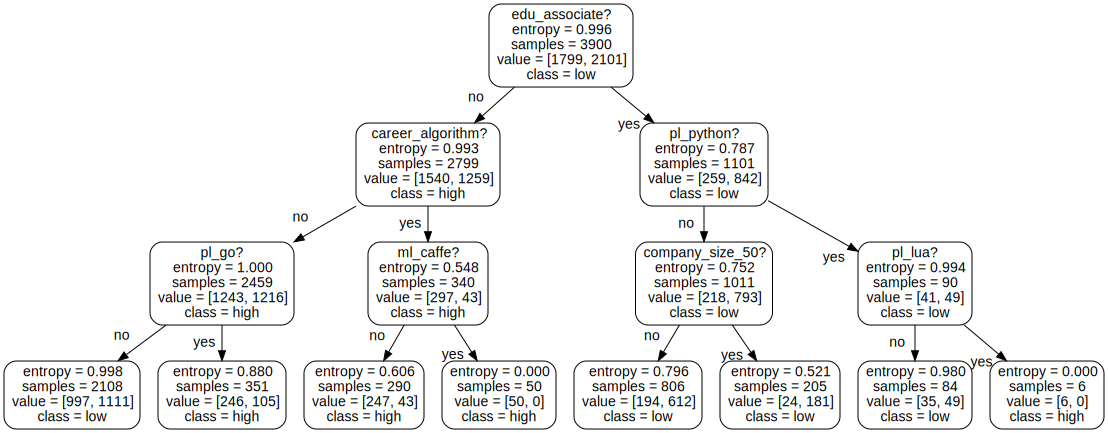

In [24]:
graph = graphviz.Source(dot_data) 
graph.render('./data/my_dt', format='png')
graph

# Decision Tree with Scikit-Learn

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model=dt.fit(X_train, y_train)

In [26]:
model.score(X_train, y_train)

0.6415384615384615

In [27]:
model.score(X_test, y_test)

0.6387487386478304

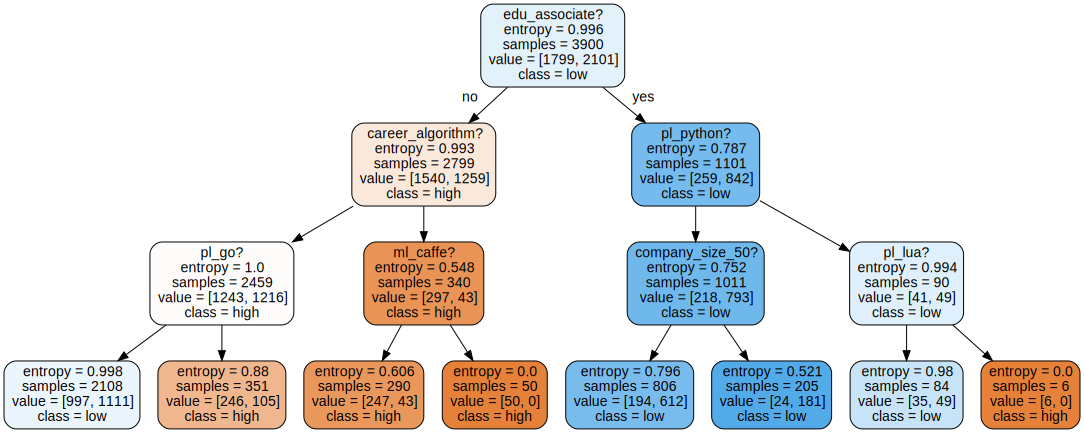

In [28]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=['high','low'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
new_dot_data=dot_data.replace('True','no').replace('False','yes').replace(' &le; 0.5','?')
graph = graphviz.Source(new_dot_data) 
graph.render('./data/dt_sklearn', format='png')
graph